Rhys M. Adams

Let's say you have a set of amino acid sequences ($\bf s$) and some sort of phenotype ($f$) associated with each sequence. You want to predict the phenotype of unknown sequences. One way to do this is by adding up the contributions of single mutations via a Position Weight Matrix (PWM) model (e.g. Stormo, Bioinformatics 2000). What exactly should you add up? In this notebook, I demonstrate a method, monotonic_fit, that transforms the data to maximize PWM prediction to actual values.

Let's get all of the imports out of the way and initialize a few generic constants.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
from scipy.stats import linregress
#The following two are custom libraries
#makeSparse converts integer sequences into a sparse array that allows for quick linear algebra
from make_A import makeSparse
#monotonic fit tries to find a monotonic, non-linear transformation that yields the most additive PWM
from monotonic_fit import monotonic_fit
np.random.seed(0)
pylab.rcParams['font.size'] = 18

Let's sample all sequences with single mutations, and then randomly sample sequences with an average of 2 mutations (seq). Finally we convert the sequences (seq) to a sparse matrix, A.

In [2]:
num_seq = 100000
mut_rate = 2
seq_length = 20
alphabet_size = 20 #i.e. amino acids
num_muts = np.random.poisson(mut_rate, num_seq)
wt_seq = np.zeros(seq_length)
seq = []
for ii in range(seq_length):
    for jj in range(1, alphabet_size):
        curr = np.zeros(seq_length)
        curr[ii] = jj
        seq.append(curr)

for muts in num_muts:
    curr = np.zeros(seq_length)
    mut_pos = np.random.permutation(seq_length)[:muts]
    curr[mut_pos] = np.random.randint(1,alphabet_size)
    seq.append(curr)

_, A = makeSparse(seq, wt_seq, alphabet_size)

If we assign an energy to each mutant, and list them as a vector (x), we can quickly estimate the total energy by calculating $\bf E = \bf A\cdot x$. Let's generate some random PWM "energies" (x) for our sequences, and calculate their total energies (E), and then add some noise (epsilon). Finally, we simulate our measurement boundaries (lims). 

In [3]:
noise_strength = 1./2
x = np.random.randn(A.shape[1])
E_original = A.dot(x)
epsilon = np.random.randn(E_original.shape[0]) * np.std(E_original) * noise_strength
E = E_original + epsilon
lims = np.array([np.sort(E)[2000], np.sort(E)[-2000]]) #this defines boundary methods. 

E_scale = lims[1]-lims[0]
rel_E = E / E_scale

Let's convert energies to some measurable phenotype (f). In this case, I use sin to represent the distortion that might arise from experimental error in measuring a phenotype.

In [4]:
def make_f(transform, lims):
    f_lims = np.sort(transform(lims))
    f = transform(E)
    f[f<f_lims[0]] = f_lims[0]
    f[f>f_lims[1]] = f_lims[1]
    return f, f_lims

g_inv = lambda x:np.sin(2*x) + 2*x
f, f_lims = make_f(g_inv, lims)

$\bf \text{Problem definition}$ At this point we have all of the variables we need to define the problem: ${\bf f} = g^{-1}({\bf E})$, and ${\bf E} = {\bf A \cdot x}$. The question fundamentally is this: given that ${\bf f}$ and ${\bf A}$ are known, can we infer a monotonic function $g$ that gives us the original energies ${\bf E}$? I set up this problem as

argmin$_g (g({\bf f}) - {\bf A} \cdot g({\bf f_1}))^T\cdot (g({\bf f}) - {\bf A} \cdot g({\bf f_1})) + \alpha \int \left (\frac{\partial^2 g(f)}{\partial f^2}\right )^2 df$

where ${\bf f_1}$ is the set of measurements for the single mutants corresponding to $\bf x$, and the fit is subject to constraints 

$g_{max} - g_{min} = 1$, $g$ has a range of 1

$g(f_{wt}) = 0$, the reference sequence has an energy of 0

$g(f+|c|) - g(f) >0 $, $g$ is monotonic

and the constraint that the PWM cannot exceed $g_{min}$ and $g_{max}$,
$g_{min} \le {\bf A_i} \cdot g({\bf f_1}) \le g_{max}$

Back to the coding, I define a helper function plotting hyper-parameter scans.

In [5]:
def plot_scan(alphas, Rsquare, ax, full_height=True):
    ax.semilogx(alphas, Rsquare)
    ax.axhline(1-objective[-1], c=[0.3,0.3,0.3])
    best_ind = np.argsort(Rsquare)[-1]
    ax.scatter(alphas[best_ind], Rsquare[best_ind],s=100, c=[1,0,0])
    ax.set_xlim([np.min(alphas), np.max(alphas)])
    ax.text(0.05,0.1,r'best $R^2$=%.3f'%(Rsquare[best_ind]), transform=ax.transAxes)
    if full_height:
        ax.set_ylim([0,1])

Finally I sample different numbers of sequences (i.e. $10^3$, $10^4$ and all sequences), and ask how this affects the monotonic fits:

/Users/radams/Documents/Antibody_analysis_epistasis/monotonic_fit/monotonic_fit.py:98: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K = delta.T.dot(np.linalg.lstsq(W, delta)[0])
/Users/radams/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


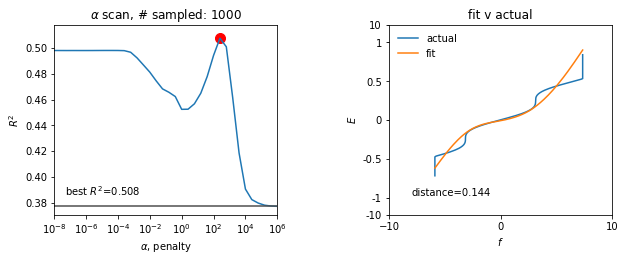

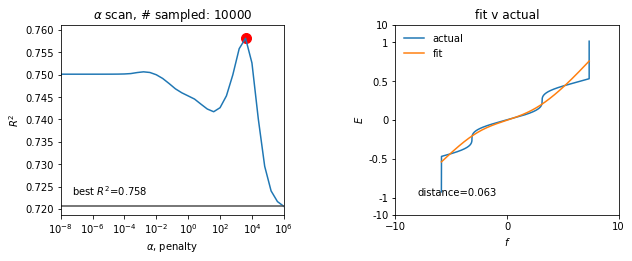

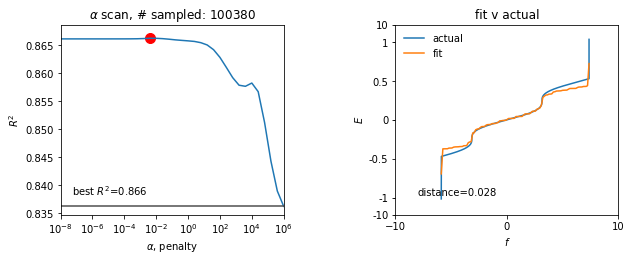

In [6]:
num_points = 36
alphas = np.logspace(-8, 6, num_points)

for sub_sample in [1000, 10000, A.shape[0]]:
    #sub_sample the unknown
    sub_A = A[:sub_sample]
    sub_f = f[:sub_sample]
    #sub_sample the original verification variables
    sub_E = rel_E[:sub_sample]
    
    #fit for Ehat = g(f)
    _, Ehat, alphas, objective = monotonic_fit(sub_A, sub_f, f_lims, alphas, name='Jupyter_sin_example', already_fit=False, suppress_out=True, random_seed=0)
    #I used 1-R^2 as the objective
    Rsquare = 1 - objective
    
    fig, axes = plt.subplots(1,2,figsize=(10,3.5))
    fig.subplots_adjust(wspace=0.5)
    ax = axes[0]
    
    #plot the scan for alpha
    plot_scan(alphas, Rsquare, ax, full_height=False)
    ax.set_ylabel(r'$R^2$')
    ax.set_xlabel(r'$\alpha$, penalty')
    ax.set_title(r'$\alpha$ scan, # sampled: %i'%sub_sample)

    #rescale Ehat so that it is roughly the same scale as E
    actually_fit = (sub_f > -8) & (sub_f < 8)

    slope, intercept, r_value, p_value, std_err = linregress(Ehat[actually_fit],sub_E[actually_fit])
    Ehat = Ehat * slope + intercept

    #compare E to Ehat
    ax = axes[1]
    ind = np.argsort(sub_E)
    ax.plot(sub_f[ind], sub_E[ind], label='actual')
    ax.plot(sub_f[ind], Ehat[ind], label='fit')
    
    #frou frou plotting commands
    ax.set_xlabel(r'$f$')
    ax.set_ylabel(r'$E$')
    ax.set_title('fit v actual')
    ax.legend(loc='upper left', frameon=False)
    ax.set_yscale('symlog', linthreshy=1, linscaley=4)
    ax.set_yticks([-10,-1,-0.5,0,0.5,1,10])
    ax.set_yticklabels(['-10','-1','-0.5','0','0.5','1','10'])
    ax.set_xticks([-10,0,10])
    ax.set_xlim([-10,10])
    
    #calculate the L2 distance between E and Ehat
    deviation = np.trapz((np.sort(sub_E[actually_fit]) - np.sort(Ehat[actually_fit]))**2, np.sort(sub_f[actually_fit]))
    ax.text(0.1,0.1,r'distance=%.3f'%(deviation), transform=ax.transAxes)

    ax.legend(loc='upper left', frameon=False)
    plt.show()


$R^2$ were calculated using 10 fold cross-validation. The fit $E$ were rescaled, so that the range is no longer 1, but this scale was arbitrary and unknown, so it should only help align the fit $\hat{E}$ to the actual $E$. Increasing the sampling rate improves the monotonic fit. As sampling increased the real answer was eventually found. This example is meant to show the limitations of this approach, so the fits only partially give a good answer until all sequences are used. 